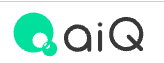

[disclaimer](../../disclaimer.txt/)

# aiQ DataHub: aiQ POS Csmr Goods Evaluation Notebook
- aiQ POS Csmr Goods consolidates sales data for products sold in retail stores such as supermarkets, drugstores, and convenience stores, organized by TICKER.
- Prescription medications, fresh foods without barcodes, and other similar items are not included in the product coverage.

In [1]:
# Commands to automatically update custom modules.
%load_ext autoreload
%autoreload 2

## Step1: Import Library

In [2]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import plotly.io
from aiq_strategy_robot.data.data_accessor import DAL

for_html = False
if for_html:
    plotly.offline.init_notebook_mode()
else:
    plotly.io.renderers.default = 'iframe'

if '../..' not in sys.path:
    sys.path.append('../..')

from libs.dataset import aiq_pos_csmr_goods as sc_goods
from libs.dataset import common as sc_common
from libs.path import DEFAULT_DIR

- Create an instance of the standard data handler.
- The data handler is an object that holds libraries for data retrieval and data processing.

In [3]:
sdh = DAL()

## Step2: Load Data to `sdh`
Since the focus here is on demonstrating data analysis, the data will be loaded through a simple loader that has been prepared separately.

In [4]:
sdh.extract.clear()

# Register various demo data into the data handler (`sdh`).
data_id_alt = sc_goods.register_csmr_goods_data(sdh, data_dir=DEFAULT_DIR)
data_id_mkt = sc_common.register_market(sdh)
data_id_funda = sc_common.register_fundamental(sdh)

# Check the registered `data_id`.
display(sdh.extract_definition)

category data_source   source    table           alias  \
data_id                                                          
1        RawData    external   sample  Unknown  pos_csmr_goods   
2        RawData    External  Unknown  Unknown  market_returns   
3        RawData    External  Unknown  Unknown           funda   

                                                   tickers  \
data_id                                                      
1        [1301, 1332, 1333, 1334, 1352, 1378, 1379, 138...   
2        [1301, 1332, 1333, 1334, 1352, 1378, 1379, 138...   
3        [1301, 1332, 1333, 1334, 1352, 1378, 1379, 138...   

                      index       start_datetime         end_datetime  
data_id                                                                
1        [TICKER, DATETIME]  2008-03-16 00:00:00  2024-09-29 00:00:00  
2        [TICKER, DATETIME]  2004-09-27 00:00:00  2024-09-26 00:00:00  
3        [TICKER, DATETIME]  2007-04-20 00:00:00  2024-05-31 00:00:00

In [5]:
# Randomly select a TICKER to use as a sample for plotting.
sample_target = "2281"

In [6]:
display(sdh.get_raw_data(data_id_alt).tail())
display(sdh.get_raw_data(data_id_mkt).tail())
display(sdh.get_raw_data(data_id_funda).tail())

VARIABLE           pos_sales     share  unit_price  unit_price_vs_ind
TICKER DATETIME                                                      
9997   2024-09-01   0.003606  0.000201    0.822752           0.580583
       2024-09-08   0.004539  0.000251    1.004957           0.707059
       2024-09-15   0.002677  0.000148    0.992262           0.700182
       2024-09-22   0.004025  0.000218    1.040915           0.729593
       2024-09-29   0.003051  0.000161    0.950448           0.680191

returns  returns_oo  returns_id  returns_on
TICKER DATETIME                                                
9997   2024-10-21 -0.009675   -0.004129   -0.006920   -0.002755
       2024-10-22  0.004158    0.004129   -0.006892    0.011050
       2024-10-23 -0.023794   -0.011050   -0.019636   -0.004158
       2024-10-24 -0.002837   -0.025318    0.002845   -0.005682
       2024-10-25 -0.011429    0.000000   -0.008584   -0.002845

sales_yoy
TICKER DATETIME             
9997   2023-03-31   0.008141
       2023-06-30  -0.030340
       2023-09-30  -0.024041
       2023-12-31  -0.024655
       2024-03-31   0.001886

> If you want to use your own financial data with the handler, please set the following flag to True. <br> Note that the sample financial data has already been adjusted for YoY.

In [7]:
USE_MY_FUNDA = False 

> If you want to use your own market data with the handler, please set the following flag to True. <br> Note that the sample market data has already been adjusted for Returns.

In [8]:
USE_MY_MKT = False 

## Step3: Correlation Analysis

### Create `AltDataEvaluator`
Given the nature of aiQ POS Csmr Goods data, it is expected that there is a correlation with financial data (quarterly sales).

We will test this hypothesis here to determine its validity.

#### The `AltDataEvaluator` will be used for evaluating alternative data.

In [9]:
from aiq_strategy_robot.evaluator import AltDataEvaluator

# Initialize AltDataEvaluator
ade = AltDataEvaluator(sdh)

# Configure the settings so that the calculation process logs are not output. (Setting it to True will enable logging)
sdh.transform.verbose = False

#### Retrieve the features from aiQ POS Csmr Goods and store them for later use.

In [10]:
features = sdh.get_raw_data(data_id_alt).columns
features

Index(['pos_sales', 'share', 'unit_price', 'unit_price_vs_ind'], dtype='object', name='VARIABLE')

#### Compare the quarterly sales data loaded in Step 2 with the `pos_sales` from POS Csmr Goods
- To make the comparison possible, resample the `pos_sales` data to match the frequency of the quarterly sales data.

In [11]:
sdh.transform.clear()
funda_Q_defs = sdh.transform.raw(data_id=data_id_funda).variables
funda_Q_defs

variable_id  data_id root_field other_roots step_001
variable_name                                                        
Funda_Sales_yoy            1        3  sales_yoy           -    raw()

In [12]:
alt_Q_defs = sdh.transform.resample_by(label=funda_Q_defs.index[0], func='mean', data_id=data_id_alt).variables
alt_Q_defs

variable_id  data_id  \
variable_name                                                              
PosCsmrGoods_Pos_sales_ResampledBy(label="Funda...            6        1   
PosCsmrGoods_Share_ResampledBy(label="Funda_Sal...            7        1   
PosCsmrGoods_Unit_price_ResampledBy(label="Fund...            8        1   
PosCsmrGoods_Unit_price_vs_ind_ResampledBy(labe...            9        1   

                                                           root_field  \
variable_name                                                           
PosCsmrGoods_Pos_sales_ResampledBy(label="Funda...          pos_sales   
PosCsmrGoods_Share_ResampledBy(label="Funda_Sal...              share   
PosCsmrGoods_Unit_price_ResampledBy(label="Fund...         unit_price   
PosCsmrGoods_Unit_price_vs_ind_ResampledBy(labe...  unit_price_vs_ind   

                                                   other_roots step_001  \
variable_name                                                             
PosCsmrGoods_Pos_sales_ResampledBy(label="Funda...           -    raw()   
PosCsmrGoods_Share_ResampledBy(label="Funda_Sal...           -    raw()   
PosCsmrGoods_Unit_price_ResampledBy(label="Fund...           -    raw()   
PosCsmrGoods_Unit_price_vs_ind_ResampledBy(labe...           -    raw()   

                                                                                             step_002  
variable_name                                                                                          
PosCsmrGoods_Pos_sales_ResampledBy(label="Funda...  resample_by(label="Funda_Sales_yoy", func="mean")  
PosCsmrGoods_Share_ResampledBy(label="Funda_Sal...  resample_by(label="Funda_Sales_yoy", func="mean")  
PosCsmrGoods_Unit_price_ResampledBy(label="Fund...  resample_by(label="Funda_Sales_yoy", func="mean")  
PosCsmrGoods_Unit_price_vs_ind_ResampledBy(labe...  resample_by(label="Funda_Sales_yoy", func="mean")

## Step 3.1: Plotting with Quarterly Sales

Plot the quarterly sales data alongside the alternative data to visually inspect the data shapes.
> It is recommended to compare with your own financial data before applying YoY adjustments.

#### Create Variables from the Base `variable` and Visually Identify Which Matches the Financial Data
- By using `sdh.transform`, you can create various variables and quickly evaluate which one has the strongest relationship with the financial data.
- For a list of `transform` processes, please refer to the sample notebook provided with the `data handler`.

In [13]:
if USE_MY_FUNDA:

    # Plot the data to visually inspect its shape.
    sdh.show_line_one_target(
        target=sample_target, # Decide which TICKER's data to plot.
        y=funda_Q_defs.index[0], # Specify the data to be displayed on the y-axis using the `variable_id`.
        X= alt_Q_defs.index, # Specify the data to be displayed on the x-axis using a list of `variable_id`s (use a list when displaying multiple graphs simultaneously).
        col_num=2, # Decide how many graphs to display in a single row.
        vname_len_limit=30, # The title will display the variable names of the X `variable_id`s, but you can specify a character limit to shorten the display.
    )
    
    # Use `resample_by` to resample the data so that it is aggregated according to the dates of the financial data.
    alt_Q_shift_defs = sdh.transform.shift(data_id=data_id_alt, periods=[0, 1, 2, 3, 4]).resample_by(label=funda_Q_defs.index[0], func='mean').variables

    # View Sales vs Pos Sales
    sdh.show_line_one_target(
        target=sample_target,
        y=funda_Q_defs.index[0],
        X=[alt_Q_shift_defs.iloc[0].name, alt_Q_shift_defs.iloc[4].name,
           alt_Q_shift_defs.iloc[8].name, alt_Q_shift_defs.iloc[12].name],
        col_num=2
    )

    # For the next step, calculate the year-over-year (YoY) change and create a variable with an additional lagged difference to address cases where trends might cause apparent correlations.
    sales_def = sdh.transform.log_diff(fields=funda_Q_ids, periods=4).diff(periods=1).variables

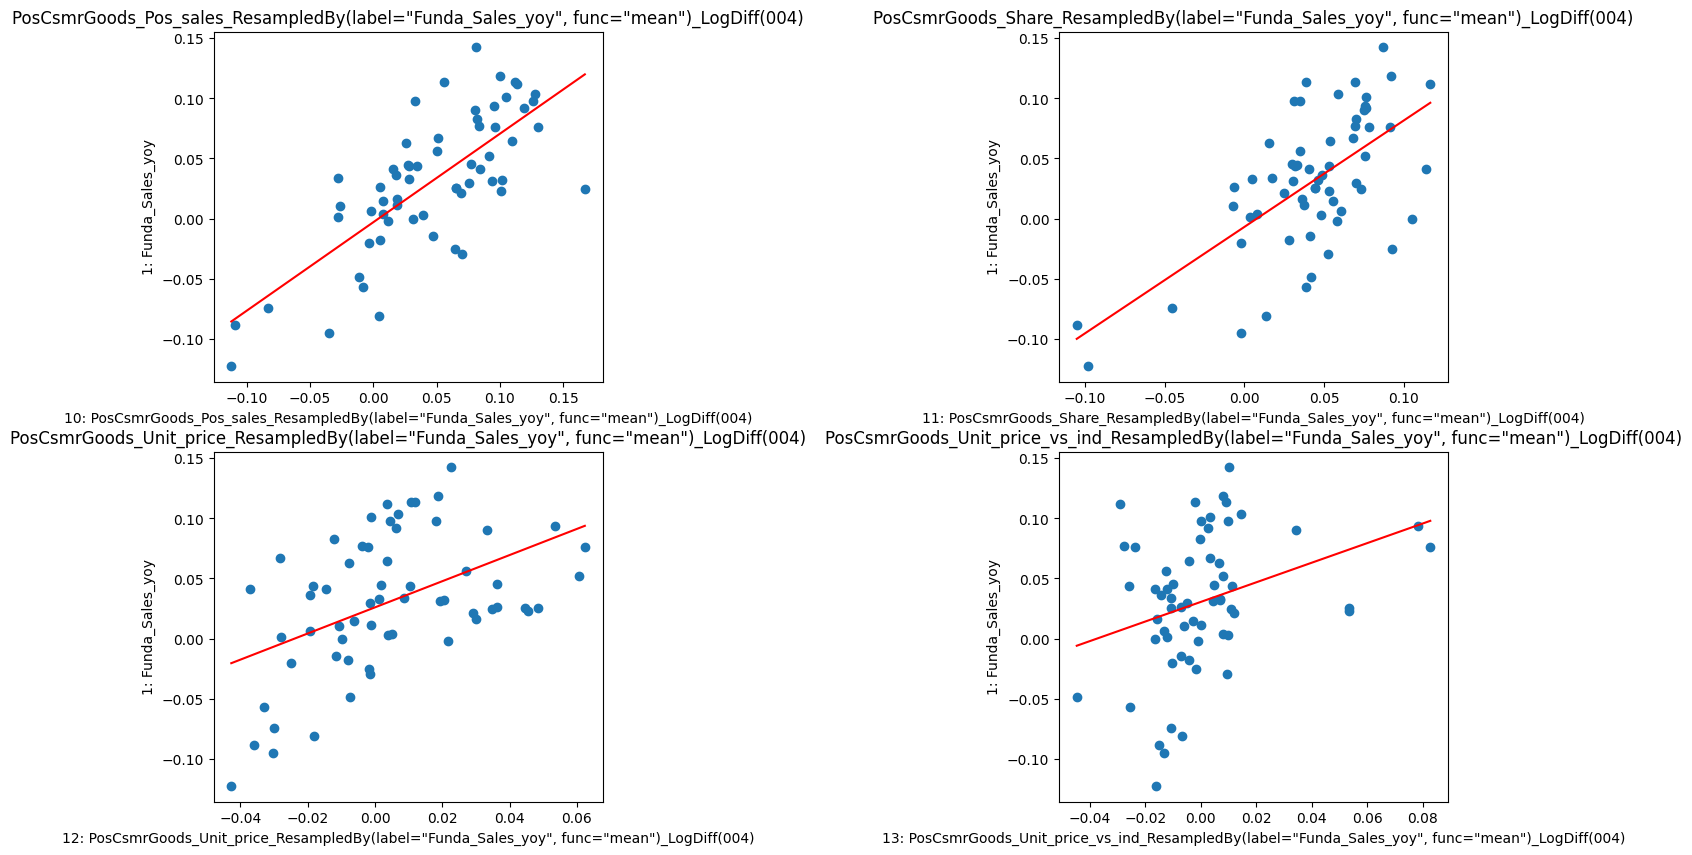

variable_id  data_id  \
variable_name                                                              
PosCsmrGoods_Unit_price_vs_ind_Shifted(003)_Res...           49        1   
PosCsmrGoods_Pos_sales_Shifted(004)_ResampledBy...           50        1   
PosCsmrGoods_Share_Shifted(004)_ResampledBy(lab...           51        1   
PosCsmrGoods_Unit_price_Shifted(004)_ResampledB...           52        1   
PosCsmrGoods_Unit_price_vs_ind_Shifted(004)_Res...           53        1   

                                                           root_field  \
variable_name                                                           
PosCsmrGoods_Unit_price_vs_ind_Shifted(003)_Res...  unit_price_vs_ind   
PosCsmrGoods_Pos_sales_Shifted(004)_ResampledBy...          pos_sales   
PosCsmrGoods_Share_Shifted(004)_ResampledBy(lab...              share   
PosCsmrGoods_Unit_price_Shifted(004)_ResampledB...         unit_price   
PosCsmrGoods_Unit_price_vs_ind_Shifted(004)_Res...  unit_price_vs_ind   

                                                   other_roots  \
variable_name                                                    
PosCsmrGoods_Unit_price_vs_ind_Shifted(003)_Res...           -   
PosCsmrGoods_Pos_sales_Shifted(004)_ResampledBy...           -   
PosCsmrGoods_Share_Shifted(004)_ResampledBy(lab...           -   
PosCsmrGoods_Unit_price_Shifted(004)_ResampledB...           -   
PosCsmrGoods_Unit_price_vs_ind_Shifted(004)_Res...           -   

                                                            step_001  \
variable_name                                                          
PosCsmrGoods_Unit_price_vs_ind_Shifted(003)_Res...  shift(periods=3)   
PosCsmrGoods_Pos_sales_Shifted(004)_ResampledBy...  shift(periods=4)   
PosCsmrGoods_Share_Shifted(004)_ResampledBy(lab...  shift(periods=4)   
PosCsmrGoods_Unit_price_Shifted(004)_ResampledB...  shift(periods=4)   
PosCsmrGoods_Unit_price_vs_ind_Shifted(004)_Res...  shift(periods=4)   

                                                                                             step_002  
variable_name                                                                                          
PosCsmrGoods_Unit_price_vs_ind_Shifted(003)_Res...  resample_by(label="Funda_Sales_yoy", func="mean")  
PosCsmrGoods_Pos_sales_Shifted(004)_ResampledBy...  resample_by(label="Funda_Sales_yoy", func="mean")  
PosCsmrGoods_Share_Shifted(004)_ResampledBy(lab...  resample_by(label="Funda_Sales_yoy", func="mean")  
PosCsmrGoods_Unit_price_Shifted(004)_ResampledB...  resample_by(label="Funda_Sales_yoy", func="mean")  
PosCsmrGoods_Unit_price_vs_ind_Shifted(004)_Res...  resample_by(label="Funda_Sales_yoy", func="mean")

variable_id  data_id root_field other_roots  \
variable_name                                                            
Funda_Sales_yoy_Diff(001)           54        3  sales_yoy           -   

                          step_001         step_002  
variable_name                                        
Funda_Sales_yoy_Diff(001)    raw()  diff(periods=1)

In [14]:
if not USE_MY_FUNDA:
    
    # Convert `pos_sales` to YoY as well for comparison with the financial data.
    alt_Q_yoy_defs = sdh.transform.log_diff(periods=4, fields=alt_Q_defs.index).variables
    
    # Plot the data to visually inspect its shape.
    sdh.show_scatter_one_target(
        target=sample_target,
        y=funda_Q_defs.index[0],
        X=alt_Q_yoy_defs.index,
        col_num=2
    )

    # Use `resample_by` to resample the data so that it is aggregated according to the dates of the financial data.
    alt_Q_shift_defs = sdh.transform.shift(data_id=data_id_alt, periods=[0, 1, 2, 3, 4]).resample_by(label=funda_Q_defs.index[0], func='mean').variables

    # To address cases where trends might cause apparent correlations, create a variable with an additional lagged difference.
    sales_def = sdh.transform.diff(fields=funda_Q_defs.index, periods=1).variables
    sales_nm = sales_def.iloc[0].name

    display(alt_Q_shift_defs.tail())
    display(sales_def)

#### Verify using variables that have been lagged with the first difference of the alternative data features.

In [15]:
alt_Q_shift_logdiff_defs = sdh.transform.log_diff(fields=alt_Q_shift_defs.index, periods=4).diff(periods=1).variables
display(alt_Q_shift_logdiff_defs.head())

variable_id  data_id  \
variable_name                                                              
PosCsmrGoods_Pos_sales_Shifted(000)_ResampledBy...           75        1   
PosCsmrGoods_Share_Shifted(000)_ResampledBy(lab...           76        1   
PosCsmrGoods_Unit_price_Shifted(000)_ResampledB...           77        1   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...           78        1   
PosCsmrGoods_Pos_sales_Shifted(001)_ResampledBy...           79        1   

                                                           root_field  \
variable_name                                                           
PosCsmrGoods_Pos_sales_Shifted(000)_ResampledBy...          pos_sales   
PosCsmrGoods_Share_Shifted(000)_ResampledBy(lab...              share   
PosCsmrGoods_Unit_price_Shifted(000)_ResampledB...         unit_price   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...  unit_price_vs_ind   
PosCsmrGoods_Pos_sales_Shifted(001)_ResampledBy...          pos_sales   

                                                   other_roots  \
variable_name                                                    
PosCsmrGoods_Pos_sales_Shifted(000)_ResampledBy...           -   
PosCsmrGoods_Share_Shifted(000)_ResampledBy(lab...           -   
PosCsmrGoods_Unit_price_Shifted(000)_ResampledB...           -   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...           -   
PosCsmrGoods_Pos_sales_Shifted(001)_ResampledBy...           -   

                                                            step_001  \
variable_name                                                          
PosCsmrGoods_Pos_sales_Shifted(000)_ResampledBy...  shift(periods=0)   
PosCsmrGoods_Share_Shifted(000)_ResampledBy(lab...  shift(periods=0)   
PosCsmrGoods_Unit_price_Shifted(000)_ResampledB...  shift(periods=0)   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...  shift(periods=0)   
PosCsmrGoods_Pos_sales_Shifted(001)_ResampledBy...  shift(periods=1)   

                                                                                             step_002  \
variable_name                                                                                           
PosCsmrGoods_Pos_sales_Shifted(000)_ResampledBy...  resample_by(label="Funda_Sales_yoy", func="mean")   
PosCsmrGoods_Share_Shifted(000)_ResampledBy(lab...  resample_by(label="Funda_Sales_yoy", func="mean")   
PosCsmrGoods_Unit_price_Shifted(000)_ResampledB...  resample_by(label="Funda_Sales_yoy", func="mean")   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...  resample_by(label="Funda_Sales_yoy", func="mean")   
PosCsmrGoods_Pos_sales_Shifted(001)_ResampledBy...  resample_by(label="Funda_Sales_yoy", func="mean")   

                                                               step_003  \
variable_name                                                             
PosCsmrGoods_Pos_sales_Shifted(000)_ResampledBy...  log_diff(periods=4)   
PosCsmrGoods_Share_Shifted(000)_ResampledBy(lab...  log_diff(periods=4)   
PosCsmrGoods_Unit_price_Shifted(000)_ResampledB...  log_diff(periods=4)   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...  log_diff(periods=4)   
PosCsmrGoods_Pos_sales_Shifted(001)_ResampledBy...  log_diff(periods=4)   

                                                           step_004  
variable_name                                                        
PosCsmrGoods_Pos_sales_Shifted(000)_ResampledBy...  diff(periods=1)  
PosCsmrGoods_Share_Shifted(000)_ResampledBy(lab...  diff(periods=1)  
PosCsmrGoods_Unit_price_Shifted(000)_ResampledB...  diff(periods=1)  
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...  diff(periods=1)  
PosCsmrGoods_Pos_sales_Shifted(001)_ResampledBy...  diff(periods=1)

#### Execute the correlation calculations one by one.

In [16]:
rho_pool = ade.compu_rho_by_df(alt_Q_shift_logdiff_defs, sales_def, group_by='step_001')
display(rho_pool.xs('t-val', level=1).sort_values(rho_pool.columns[0], ascending=False))

shift(periods=0)  shift(periods=1)  shift(periods=2)  \
pos_sales                 14.313396         11.316954          8.413976   
share                      5.059071          4.395785          3.592493   
unit_price_vs_ind          1.427204          1.023652          0.415687   
unit_price                 0.051041         -1.004597         -1.668304   

                   shift(periods=3)  shift(periods=4)  
pos_sales                  5.932159          4.769389  
share                      2.625311          3.562496  
unit_price_vs_ind         -0.299486         -0.735402  
unit_price                -2.579399         -2.617638

In [17]:
# Retrieve the results from the contents of the pooled DataFrame.
display(rho_pool.xs('rho', level=1).sort_values(rho_pool.columns[0], ascending=False))

shift(periods=0)  shift(periods=1)  shift(periods=2)  \
pos_sales                  0.123923          0.098293          0.073251   
share                      0.044098          0.038337          0.031345   
unit_price_vs_ind          0.012451          0.008934          0.003629   
unit_price                 0.000445         -0.008767         -0.014562   

                   shift(periods=3)  shift(periods=4)  
pos_sales                  0.052040          0.041871  
share                      0.023056          0.031288  
unit_price_vs_ind         -0.002631         -0.006462  
unit_price                -0.022653         -0.022995

#### Correlation values can also be calculated on a Ticker-by-Ticker basis
- Below, the top 5 TICKERs are selected, and their relationships are plotted.

In [18]:
alt_Q_shift_1_logdiff_defs = sdh.transform.search_applied_methods(alt_Q_shift_logdiff_defs, {'step_001': 'shift(periods=1)'})
rho_time = ade.compu_rho(alt_Q_shift_1_logdiff_defs.index, sales_nm, by='ticker', rename_features=alt_Q_shift_1_logdiff_defs.root_field)
rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).head()

pos_sales     share  unit_price  unit_price_vs_ind
TICKER                                                    
2226     9.500869  6.554818   -0.042537           0.298083
2220     7.280671  5.711003   -0.434502          -1.965568
2804     6.135112  0.524333    1.046190          -1.138697
2208     5.889190  1.437646    2.672743           1.524452
2908     5.538624  0.398367    0.781101           0.905671

In [19]:
rho_time = ade.compu_rho_by_df(alt_Q_shift_logdiff_defs, sales_def, 'step_001', by='ticker')
rho_time.loc['shift(periods=1)'].T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).head()

pos_sales     share  unit_price  unit_price_vs_ind
TICKER                                                    
2226     9.500869  6.554818   -0.042537           0.298083
2220     7.280671  5.711003   -0.434502          -1.965568
2804     6.135112  0.524333    1.046190          -1.138697
2208     5.889190  1.437646    2.672743           1.524452
2908     5.538624  0.398367    0.781101           0.905671

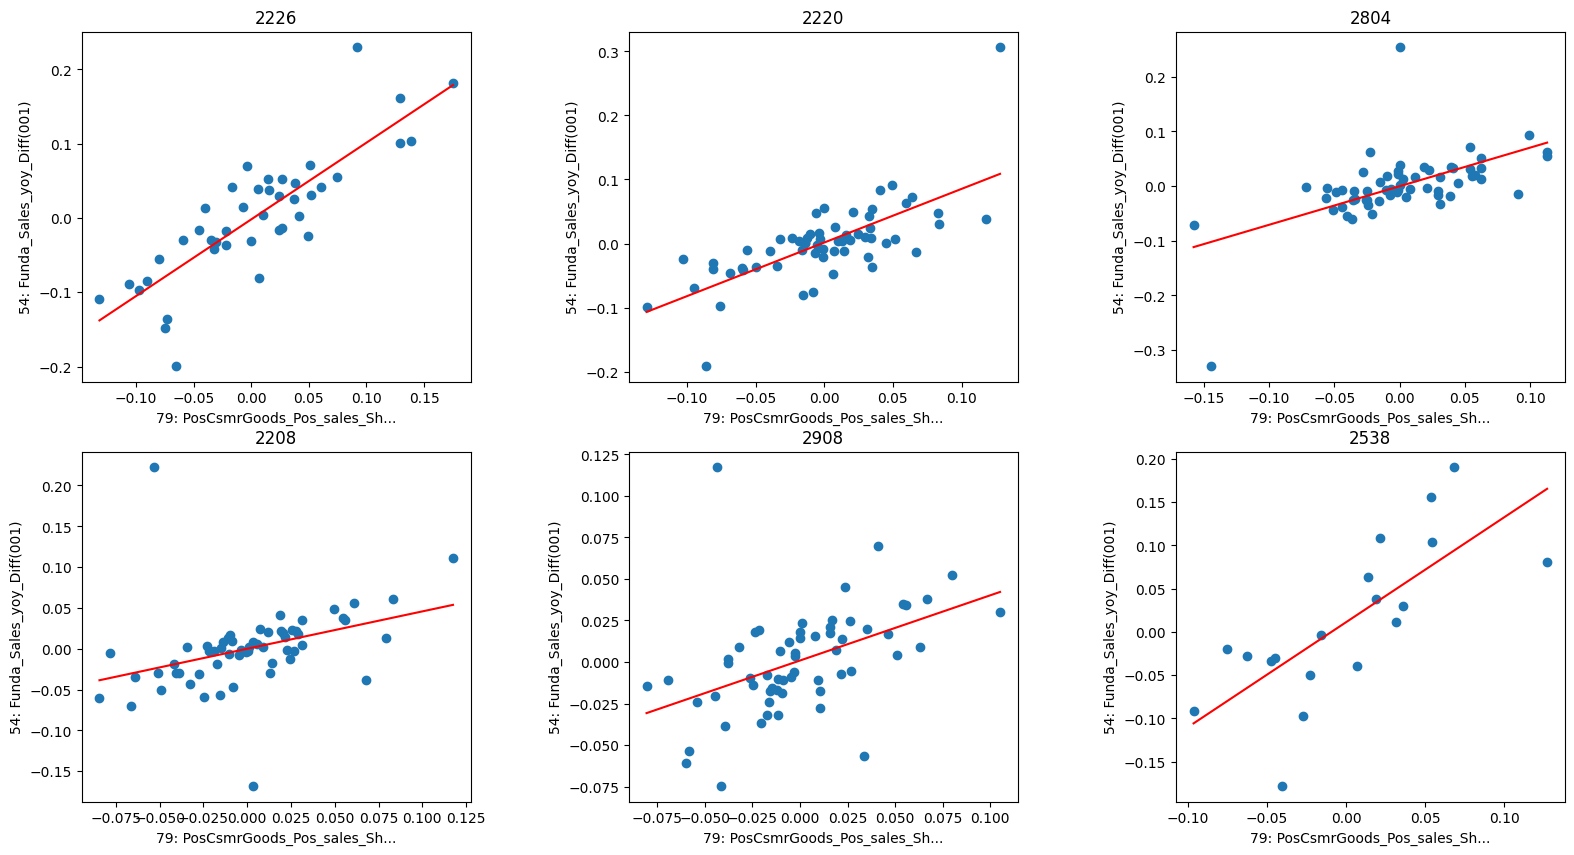

In [20]:
top6tickers = rho_time.loc['shift(periods=1)'].T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=sales_nm,
    x=alt_Q_shift_1_logdiff_defs.index[0],
    targets=top6tickers,
    col_num=3,
    vname_len_limit=25,
)

### Step 3.2: Correlation with Stock Price Changes
- Having confirmed a strong relationship between financial data and POS Csmr Goods, the next step is to examine the correlation with stock price changes.
- To align the stock price data with the POS data, resample it to weekly data for comparison.

In [21]:
if USE_MY_MKT:
     mkt_W_close = sdh.transform.resample(data_id=data_id_mkt, rule='W', fields='close', func='last').variables
else:
     mkt_W_close = sdh.transform.fillna(0, data_id=data_id_mkt, fields='returns').cumsum().resample(rule='W', func='last').variables
mkt_W_close_nm = mkt_W_close.iloc[0].name

alt_defs = sdh.transform.raw(data_id=data_id_alt).variables
alt_defs = pd.concat([alt_defs,  sdh.transform.mul(data_id=data_id_alt, x1field='pos_sales', x2field='unit_price').variables])
alt_defs = pd.concat([alt_defs,  sdh.transform.mul(data_id=data_id_alt, x1field='pos_sales', x2field='share').variables])
alt_W_defs = sdh.transform.resample(rule='W', func='mean', fields=alt_defs.index).variables

display(mkt_W_close)
display(alt_W_defs)

variable_id  data_id  \
variable_name                                                              
MarketReturns_Returns_Fillna(value=0.0)_CumSum(...           97        2   

                                                   root_field other_roots  \
variable_name                                                               
MarketReturns_Returns_Fillna(value=0.0)_CumSum(...    returns           -   

                                                             step_001  \
variable_name                                                           
MarketReturns_Returns_Fillna(value=0.0)_CumSum(...  fillna(value=0.0)   

                                                    step_002  \
variable_name                                                  
MarketReturns_Returns_Fillna(value=0.0)_CumSum(...  cumsum()   

                                                                                             step_003  
variable_name                                                                                          
MarketReturns_Returns_Fillna(value=0.0)_CumSum(...  resample(rule="W", func="last", origin="start_...

variable_id  data_id  \
variable_name                                                              
PosCsmrGoods_Pos_sales_Resampled(W|mean, origin...          100        1   
PosCsmrGoods_Share_Resampled(W|mean, origin="st...          101        1   
PosCsmrGoods_Unit_price_Resampled(W|mean, origi...          102        1   
PosCsmrGoods_Unit_price_vs_ind_Resampled(W|mean...          103        1   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...          104        1   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Share)_...          105        1   

                                                           root_field  \
variable_name                                                           
PosCsmrGoods_Pos_sales_Resampled(W|mean, origin...          pos_sales   
PosCsmrGoods_Share_Resampled(W|mean, origin="st...              share   
PosCsmrGoods_Unit_price_Resampled(W|mean, origi...         unit_price   
PosCsmrGoods_Unit_price_vs_ind_Resampled(W|mean...  unit_price_vs_ind   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...          pos_sales   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Share)_...          pos_sales   

                                                      other_roots step_001  \
variable_name                                                                
PosCsmrGoods_Pos_sales_Resampled(W|mean, origin...              -        -   
PosCsmrGoods_Share_Resampled(W|mean, origin="st...              -        -   
PosCsmrGoods_Unit_price_Resampled(W|mean, origi...              -        -   
PosCsmrGoods_Unit_price_vs_ind_Resampled(W|mean...              -        -   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  [1]unit_price    raw()   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Share)_...       [1]share    raw()   

                                                                                step_002  \
variable_name                                                                              
PosCsmrGoods_Pos_sales_Resampled(W|mean, origin...                                 raw()   
PosCsmrGoods_Share_Resampled(W|mean, origin="st...                                 raw()   
PosCsmrGoods_Unit_price_Resampled(W|mean, origi...                                 raw()   
PosCsmrGoods_Unit_price_vs_ind_Resampled(W|mean...                                 raw()   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  mul(x2field=PosCsmrGoods_Unit_price)   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Share)_...       mul(x2field=PosCsmrGoods_Share)   

                                                                                             step_003  
variable_name                                                                                          
PosCsmrGoods_Pos_sales_Resampled(W|mean, origin...  resample(rule="W", func="mean", origin="start_...  
PosCsmrGoods_Share_Resampled(W|mean, origin="st...  resample(rule="W", func="mean", origin="start_...  
PosCsmrGoods_Unit_price_Resampled(W|mean, origi...  resample(rule="W", func="mean", origin="start_...  
PosCsmrGoods_Unit_price_vs_ind_Resampled(W|mean...  resample(rule="W", func="mean", origin="start_...  
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  resample(rule="W", func="mean", origin="start_...  
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Share)_...  resample(rule="W", func="mean", origin="start_...

#### Plotting with Stock Prices

Similar to the comparison with financial data, plot the data to understand its shape and structure.

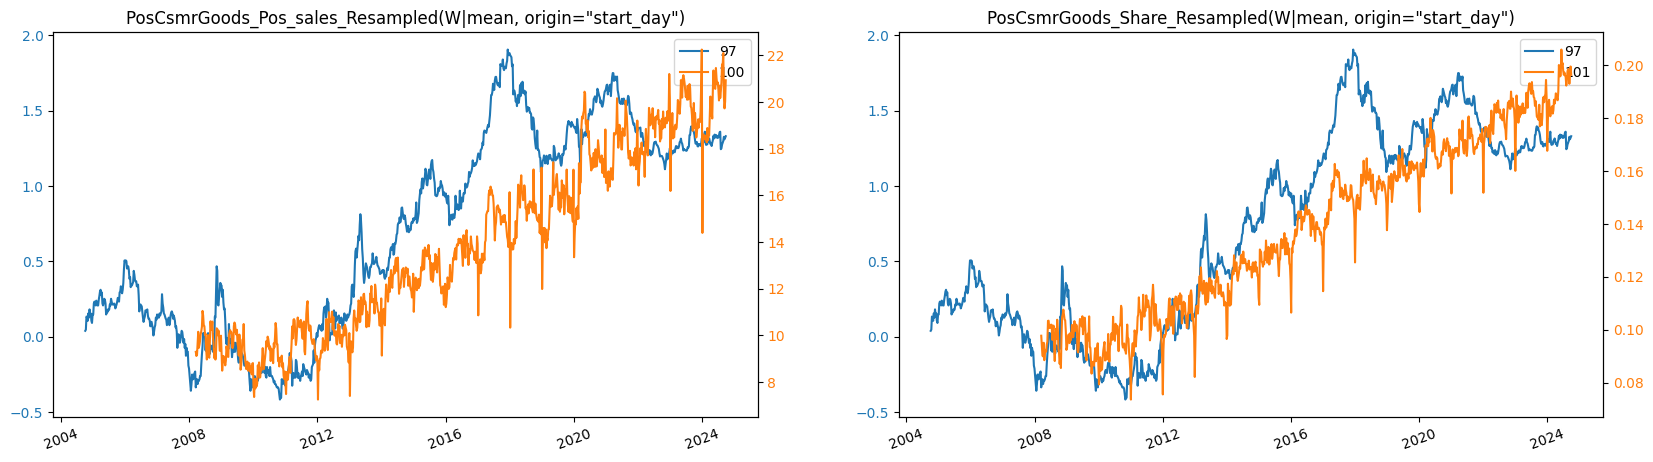

In [22]:
sdh.show_line_one_target(
    target=sample_target,
    y=mkt_W_close_nm,
    X=alt_W_defs.index[:2],
    col_num=2
)

##### Explore the Optimal Shift Interval in the Same Way as the Comparison with Financial Data

In [23]:
alt_W_shift_x_SMA_defs = sdh.transform.shift(fields=alt_defs.index, periods=[0, 1, 2, 3, 4, 5, 6, 7, 8]).resample(rule='W', func='mean').sma(periods=[4, 8, 12]).variables
display(alt_W_shift_x_SMA_defs.head())

variable_id  data_id  \
variable_name                                                              
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...          194        1   
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...          195        1   
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...          196        1   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...          197        1   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...          198        1   

                                                           root_field  \
variable_name                                                           
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...          pos_sales   
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...              share   
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...         unit_price   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...  unit_price_vs_ind   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...          pos_sales   

                                                      other_roots step_001  \
variable_name                                                                
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...              -        -   
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...              -        -   
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...              -        -   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...              -        -   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  [1]unit_price    raw()   

                                                                                step_002  \
variable_name                                                                              
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...                                     -   
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...                                     -   
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...                                     -   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...                                     -   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  mul(x2field=PosCsmrGoods_Unit_price)   

                                                            step_003  \
variable_name                                                          
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...  shift(periods=0)   
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...  shift(periods=0)   
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...  shift(periods=0)   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...  shift(periods=0)   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  shift(periods=0)   

                                                                                             step_004  \
variable_name                                                                                           
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...  resample(rule="W", func="mean", origin="start_...   
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...  resample(rule="W", func="mean", origin="start_...   
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...  resample(rule="W", func="mean", origin="start_...   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...  resample(rule="W", func="mean", origin="start_...   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  resample(rule="W", func="mean", origin="start_...   

                                                          step_005  
variable_name                                                       
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...  sma(periods=4)  
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...  sma(periods=4)  
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...  sma(periods=4)  
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...  sma(periods=4)  
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  sma(periods=4)

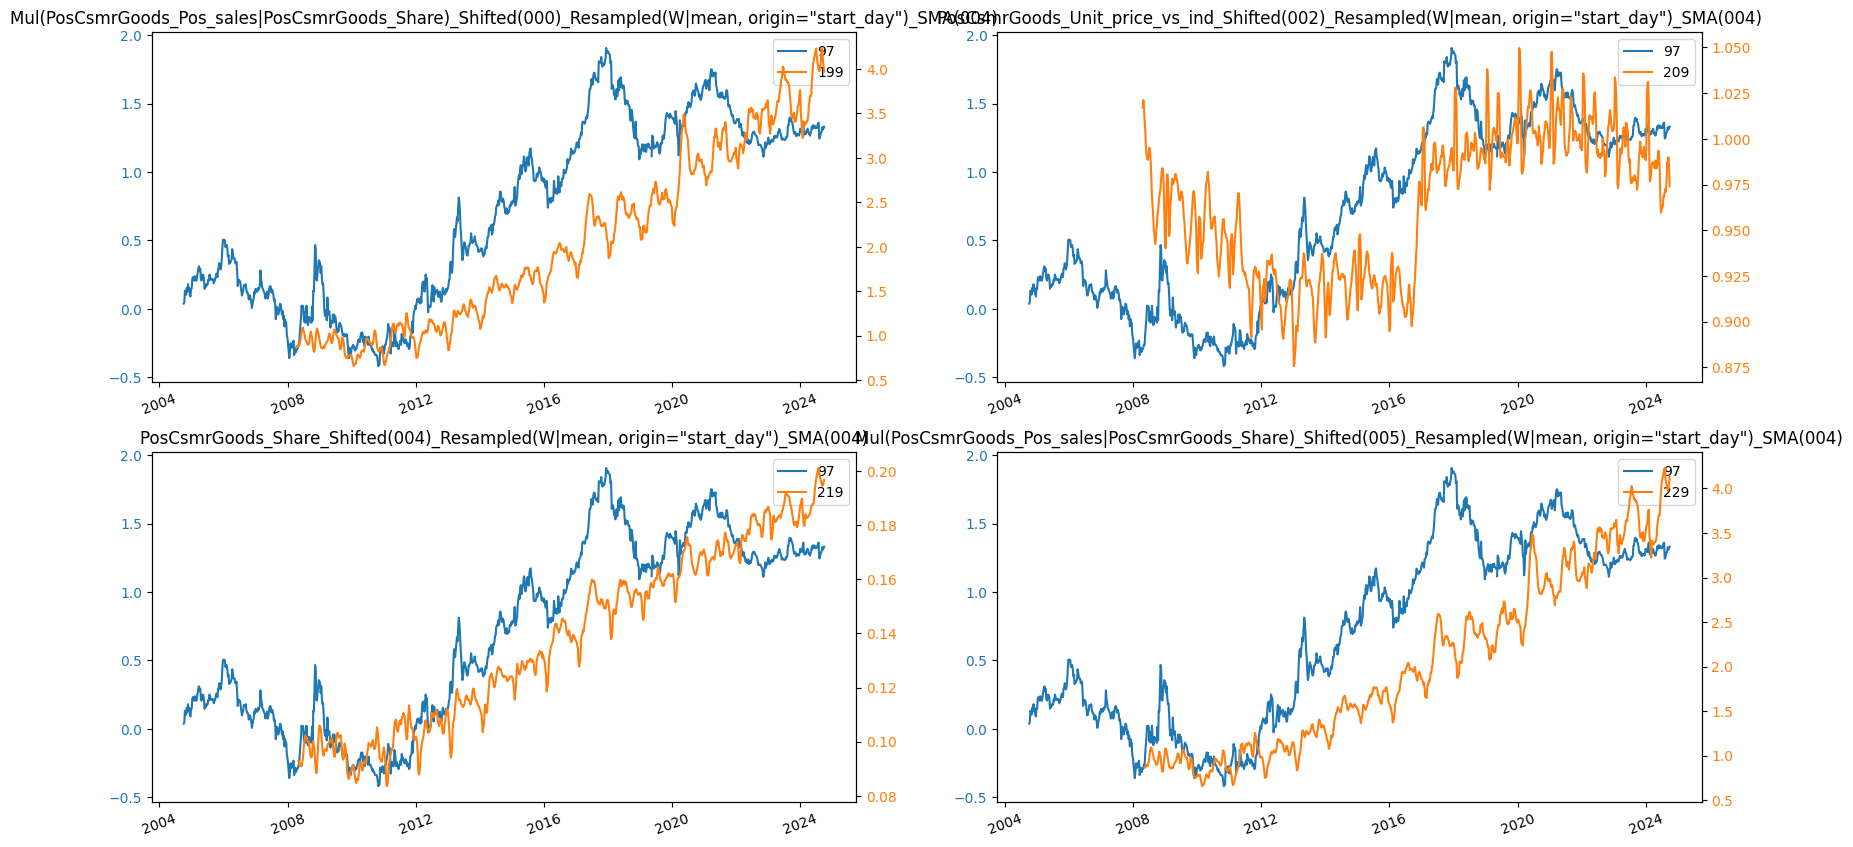

In [24]:
# View Sales vs Pos Sales
sdh.show_line_one_target(
    target=sample_target,
    y=mkt_W_close_nm,
    X=[alt_W_shift_x_SMA_defs.index[5], alt_W_shift_x_SMA_defs.index[15], 
       alt_W_shift_x_SMA_defs.index[25], alt_W_shift_x_SMA_defs.index[35]],
    col_num=2
)

> Make `return`

In [25]:
if USE_MY_MKT:
    close_ret = sdh.transform.dropna(fields=mkt_W_close.iloc[0].name, how='all').log_diff(periods=1, names='ret').variables
else:
    close_ret = sdh.transform.dropna(fields=mkt_W_close.iloc[0].name, how='all').diff(periods=1, names='ret').variables

> Calculate the year-over-year (YoY) change for the same week before performing the correlation analysis.

In [26]:
alt_W_shift_x_sma12_logdiff_defs = sdh.transform.log_diff(fields=alt_W_shift_x_SMA_defs.index, periods=52).variables
display(alt_W_shift_x_sma12_logdiff_defs.head())

variable_id  data_id  \
variable_name                                                              
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...          358        1   
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...          359        1   
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...          360        1   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...          361        1   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...          362        1   

                                                           root_field  \
variable_name                                                           
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...          pos_sales   
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...              share   
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...         unit_price   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...  unit_price_vs_ind   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...          pos_sales   

                                                      other_roots step_001  \
variable_name                                                                
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...              -        -   
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...              -        -   
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...              -        -   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...              -        -   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  [1]unit_price    raw()   

                                                                                step_002  \
variable_name                                                                              
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...                                     -   
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...                                     -   
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...                                     -   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...                                     -   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  mul(x2field=PosCsmrGoods_Unit_price)   

                                                            step_003  \
variable_name                                                          
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...  shift(periods=0)   
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...  shift(periods=0)   
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...  shift(periods=0)   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...  shift(periods=0)   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  shift(periods=0)   

                                                                                             step_004  \
variable_name                                                                                           
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...  resample(rule="W", func="mean", origin="start_...   
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...  resample(rule="W", func="mean", origin="start_...   
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...  resample(rule="W", func="mean", origin="start_...   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...  resample(rule="W", func="mean", origin="start_...   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  resample(rule="W", func="mean", origin="start_...   

                                                          step_005  \
variable_name                                                        
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...  sma(periods=4)   
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...  sma(periods=4)   
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...  sma(periods=4)   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...  sma(periods=4)   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  sma(periods=4)   

                                                                step_006  
variable

> Calculate the correlation coefficient and its T-value.

In [27]:
# We can see which variables have higher correlations.
rho_pool = ade.compu_rho_by_df(alt_W_shift_x_sma12_logdiff_defs, close_ret, group_by=['step_003', 'step_005'])
display(rho_pool.xs('t-val', level=1).sort_values(rho_pool.columns[0], ascending=False))

shift(periods=0) shift(periods=1) shift(periods=2)  \
                          sma(periods=4)   sma(periods=4)   sma(periods=4)   
pos_sales                       5.071169         5.952905         6.229815   
pos_sales*[1]share              4.521016         5.600229         5.554512   
pos_sales*[1]unit_price         4.090987         5.021341         5.724382   
share                           2.726691         3.327248         2.846193   
unit_price_vs_ind              -0.048809         0.030910         0.854985   
unit_price                     -0.061860         0.398179         1.257327   

                        shift(periods=3) shift(periods=4) shift(periods=5)  \
                          sma(periods=4)   sma(periods=4)   sma(periods=4)   
pos_sales                       5.939782         6.091400         5.231459   
pos_sales*[1]share              5.416464         5.468508         4.629135   
pos_sales*[1]unit_price         5.411464         5.664035         5.301189   
share                           2.752518         3.135286         2.378417   
unit_price_vs_ind               0.487846         0.250673         0.210000   
unit_price                      0.877817         0.817276         0.680151   

                        shift(periods=6) shift(periods=7) shift(periods=8)  \
                          sma(periods=4)   sma(periods=4)   sma(periods=4)   
pos_sales                       4.992043         5.525107         5.550247   
pos_sales*[1]share              4.417658         4.551681         4.567927   
pos_sales*[1]unit_price         4.901236         5.356278         5.216275   
share                           2.271145         2.028261         1.906477   
unit_price_vs_ind               0.366333         0.538934         0.878927   
unit_price                      0.794051         1.258055         0.921138   

                        shift(periods=0)  ... shift(periods=8)  \
                          sma(periods=8)  ...   sma(periods=8)   
pos_sales                       6.187110  ...         5.058159   
pos_sales*[1]share              5.735951  ...         4.302144   
pos_sales*[1]unit_price         5.251183  ...         5.032645   
share                           3.345869  ...         1.913581   
unit_price_vs_ind               0.096597  ...         0.373745   
unit_price                      0.473225  ...         1.251970   

                        shift(periods=0) shift(periods=1) shift(periods=2)  \
                         sma(periods=12)  sma(periods=12)  sma(periods=12)   
pos_sales                       6.731222         6.828559         6.374128   
pos_sales*[1]share              5.721566         5.719880         5.362417   
pos_sales*[1]unit_price         5.981384         6.194367         6.077454   
share                           3.289406         3.271027         2.907455   
unit_price_vs_ind               0.190367         0.150382         0.385243   
unit_price                      0.839543         0.907005         1.052854   

                        shift(periods=3) shift(periods=4) shift(periods=5)  \
                         sma(periods=12)  sma(periods=12)  sma(periods=12)   
pos_sales                       6.360348         6.222286         5.676769   
pos_sales*[1]share              5.369964         5.367003         5.020242   
pos_sales*[1]unit_price         6.057187         6.114184         5.747226   
share                           2.724344         2.744613         2.476592   
unit_price_vs_ind               0.552825         0.418609         0.658757   
unit_price                      1.198018         1.292385         1.446259   

                        shift(periods=6) shift(periods=7) shift(periods=8)  
                         sma(periods=12)  sma(periods=12)  sma(periods=12)  
pos_sales                       5.141700         5.015015         4.520522  
pos_sales*[1]share              4.540252         4.289979         3.777327  
pos_sales*[1]unit_price         4.905836         4.838911     

> Select the top N Tickers with the highest correlation and visually inspect their relationships using scatter plots.

In [28]:
alt_W_shift_3_sma12_logdiff_defs = sdh.transform.search_applied_methods(alt_W_shift_x_sma12_logdiff_defs, {'step_003': 'shift(periods=3)', 'step_005': 'sma(periods=12)'})

In [29]:
rho_time1 = ade.compu_rho_by_df(alt_W_shift_3_sma12_logdiff_defs, close_ret, 'step_003', by='ticker')
rho_time1.droplevel(0).T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).head()

pos_sales     share  unit_price  unit_price_vs_ind  \
TICKER                                                       
5194     3.858180  3.874467    2.247345           1.858993   
2820     2.889310  2.535615    1.338806           0.993520   
2884     2.783116  0.373418    0.342155           1.329163   
2281     2.751881  2.685866    2.032828           0.269327   
2216     2.700906  1.297615    1.188294           0.788307   

        pos_sales*[1]unit_price  pos_sales*[1]share  
TICKER                                               
5194                   3.952662            3.925663  
2820                   2.730842            2.829138  
2884                   2.608122            2.217537  
2281                   2.807988            2.980067  
2216                   2.766558            2.301196

## Step 4: Quantile Backtest
- Based on the variables created in Step 3, various factors will be generated and calculations will be performed.
- Here, the 12-week moving average of `pos_sales` is selected as the factor value.
- In practice, you should vary hyperparameters such as the moving average period and shift intervals to ensure that the backtest results are not significantly affected.

In [30]:
# Create a tercile (three-quantile) portfolio.
nq = 3

# Assume one-way transaction costs.
exe_cost = 0.0005

In [31]:
df_of_pick = alt_W_shift_3_sma12_logdiff_defs.copy()
display(df_of_pick)

pos_sales = df_of_pick.index[0]
share = df_of_pick.index[1]
unit_price =  df_of_pick.index[2]
pos_sales_and_uprice = df_of_pick.loc[df_of_pick['other_roots'].str.contains('unit_price')].index[0]
pos_sales_and_share = df_of_pick.loc[df_of_pick['other_roots'].str.contains('share')].index[0]

variable_id  data_id  \
variable_name                                                              
PosCsmrGoods_Pos_sales_Shifted(003)_Resampled(W...          484        1   
PosCsmrGoods_Share_Shifted(003)_Resampled(W|mea...          485        1   
PosCsmrGoods_Unit_price_Shifted(003)_Resampled(...          486        1   
PosCsmrGoods_Unit_price_vs_ind_Shifted(003)_Res...          487        1   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...          488        1   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Share)_...          489        1   

                                                           root_field  \
variable_name                                                           
PosCsmrGoods_Pos_sales_Shifted(003)_Resampled(W...          pos_sales   
PosCsmrGoods_Share_Shifted(003)_Resampled(W|mea...              share   
PosCsmrGoods_Unit_price_Shifted(003)_Resampled(...         unit_price   
PosCsmrGoods_Unit_price_vs_ind_Shifted(003)_Res...  unit_price_vs_ind   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...          pos_sales   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Share)_...          pos_sales   

                                                      other_roots step_001  \
variable_name                                                                
PosCsmrGoods_Pos_sales_Shifted(003)_Resampled(W...              -        -   
PosCsmrGoods_Share_Shifted(003)_Resampled(W|mea...              -        -   
PosCsmrGoods_Unit_price_Shifted(003)_Resampled(...              -        -   
PosCsmrGoods_Unit_price_vs_ind_Shifted(003)_Res...              -        -   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  [1]unit_price    raw()   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Share)_...       [1]share    raw()   

                                                                                step_002  \
variable_name                                                                              
PosCsmrGoods_Pos_sales_Shifted(003)_Resampled(W...                                     -   
PosCsmrGoods_Share_Shifted(003)_Resampled(W|mea...                                     -   
PosCsmrGoods_Unit_price_Shifted(003)_Resampled(...                                     -   
PosCsmrGoods_Unit_price_vs_ind_Shifted(003)_Res...                                     -   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  mul(x2field=PosCsmrGoods_Unit_price)   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Share)_...       mul(x2field=PosCsmrGoods_Share)   

                                                            step_003  \
variable_name                                                          
PosCsmrGoods_Pos_sales_Shifted(003)_Resampled(W...  shift(periods=3)   
PosCsmrGoods_Share_Shifted(003)_Resampled(W|mea...  shift(periods=3)   
PosCsmrGoods_Unit_price_Shifted(003)_Resampled(...  shift(periods=3)   
PosCsmrGoods_Unit_price_vs_ind_Shifted(003)_Res...  shift(periods=3)   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  shift(periods=3)   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Share)_...  shift(periods=3)   

                                                                                             step_004  \
variable_name                                                                                           
PosCsmrGoods_Pos_sales_Shifted(003)_Resampled(W...  resample(rule="W", func="mean", origin="start_...   
PosCsmrGoods_Share_Shifted(003)_Resampled(W|mea...  resample(rule="W", func="mean", origin="start_...   
PosCsmrGoods_Unit_price_Shifted(003)_Resampled(...  resample(rule="W", func="mean", origin="start_...   
PosCsmrGoods_Unit_price_vs_ind_Shifted(003)_Res...  resample(rule="W", func="mean", origin="start_...   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  resample(rule="W", func="mean", origin="start_...   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Share)_...  resample(rule="W", func="mean", origin="start_...   

                                                           step_005  \
variabl

### Try pos_sales factor

In [32]:
dfqret, stats, dfsigqt = ade.q_backtest(
    pos_sales,
    close_ret.iloc[0].name,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

cum.Ret   ann.Ret   ann.Std       R/R     Win_R  ann.TurnOver  \
#1           0.603294  0.039470  0.139441  0.283058  0.582183      3.005990   
#2           0.759499  0.049689  0.135579  0.366499  0.575910      5.389839   
#3           1.280145  0.083752  0.140138  0.597638  0.579674      3.035012   
#3-#1        0.676851  0.044282  0.046061  0.961376  0.569636      6.041002   
#3-#1(cost)  0.630683  0.041262  0.046046  0.896091  0.564617      6.041002   

               Max_DD  Calmar Ratio  
#1          -0.468064      0.084326  
#2          -0.429904      0.115583  
#3          -0.398461      0.210189  
#3-#1       -0.064169      0.690084  
#3-#1(cost) -0.066934      0.616458

### Try pos_sales x share factor

In [33]:
dfqret, stats, dfsigqt = ade.q_backtest(
    pos_sales_and_share,
    close_ret.iloc[0].name,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

cum.Ret   ann.Ret   ann.Std       R/R     Win_R  ann.TurnOver  \
#1           0.586804  0.038391  0.138092  0.278011  0.577164      3.089466   
#2           0.766439  0.050143  0.136636  0.366984  0.577164      5.306984   
#3           1.289921  0.084392  0.140082  0.602445  0.583438      3.049837   
#3-#1        0.703117  0.046001  0.044974  1.022816  0.560853      6.139303   
#3-#1(cost)  0.656197  0.042931  0.044964  0.954782  0.555834      6.139303   

               Max_DD  Calmar Ratio  
#1          -0.475624      0.080717  
#2          -0.435863      0.115044  
#3          -0.383917      0.219818  
#3-#1       -0.062732      0.733293  
#3-#1(cost) -0.063497      0.676105

### We try pos_sales x unit_price composite factor too

In [34]:
dfqret, stats, dfsigqt = ade.q_backtest(
    pos_sales_and_uprice,
    close_ret.iloc[0].name,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

cum.Ret   ann.Ret   ann.Std       R/R     Win_R  ann.TurnOver  \
#1           0.531050  0.034743  0.136823  0.253930  0.582183      3.278438   
#2           0.872135  0.057058  0.134407  0.424521  0.582183      5.673770   
#3           1.241449  0.081220  0.143142  0.567413  0.593476      3.102687   
#3-#1        0.710399  0.046477  0.045770  1.015450  0.572146      6.381124   
#3-#1(cost)  0.661632  0.043287  0.045759  0.945968  0.568381      6.381124   

               Max_DD  Calmar Ratio  
#1          -0.472372      0.073551  
#2          -0.420812      0.135591  
#3          -0.409494      0.198343  
#3-#1       -0.062949      0.738331  
#3-#1(cost) -0.065414      0.661730